<a href="https://colab.research.google.com/github/HariWoverine/Technical-Challenge/blob/main/Career_Copilot_LLAMA2_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine Tuning Llama2 7b with RAG system**

###### Here we install all the requirements from requirements.txt

In [2]:
import locale
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:

In [3]:
from google.colab import drive
from torch import cuda, bfloat16
import transformers
from torch import cuda
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import os
import pinecone
import time
import datasets
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
model_id = 'meta-llama/Llama-2-7b-chat-hf' # here we go with the smallest model 7b and in upcoming steps we will also quantize the model to fit it my colab

In [5]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization makes the model smaller with compute of bfloat16  -> library used bits and config
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)
# We make sure the we run it through the cuda
device

'cuda:0'

In [6]:
import os

print(os.getcwd())
from apikey import hf_auth

/content/drive/My Drive/Colab Notebooks


In [7]:
authkey_hf = hf_auth # this is my authentication done using hf auth -> get this code from your profile
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=authkey_hf
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=authkey_hf
)
model.eval()
# making sure the model is loaded in the cuda to make our computation faster
print(f"Model loaded on {device}")

(…)ma-2-7b-chat-hf/resolve/main/config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


(…)esolve/main/model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)t-hf/resolve/main/generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Model loaded on cuda:0


In [8]:
model # model's internal structure

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [9]:
# this is  the smaller model with 384 embeddings for our text
# there are bigger like openai embedidngs but this is free and small, more information on document
embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'
embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device,
                   'batch_size': 32}
)
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
#hygiene factor to check if they are loaded in cuda (as all other weights) so that weights can communicate
print(device)

(…)f3d3c277d6e90027e55de9125/.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

(…)7d6e90027e55de9125/1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(…)e2f80f3d3c277d6e90027e55de9125/README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

(…)f80f3d3c277d6e90027e55de9125/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

(…)de9125/config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

(…)d3c277d6e90027e55de9125/data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

(…)90027e55de9125/sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

(…)6e90027e55de9125/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

(…)f3d3c277d6e90027e55de9125/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)7d6e90027e55de9125/tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

(…)3d3c277d6e90027e55de9125/train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

(…)e2f80f3d3c277d6e90027e55de9125/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)80f3d3c277d6e90027e55de9125/modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

cuda:0


In [10]:
sent='Hari AI Engineer in Futurefit' # A dummy text
embeddings=embed_model.embed_documents(sent)

In [11]:
# we get a emdding for each char as shown here
# its a decent embedding at this point to generate a good RAG system
len(embeddings),len(sent)

(29, 29)

In [12]:
#View of how the data would look
import pandas as pd
pd.DataFrame(embed_model.embed_documents(sent))

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.057102,0.094101,-0.042961,0.015190,0.003591,0.019871,0.081218,0.037186,-0.010115,-0.053688,...,0.058882,0.025638,0.067378,-0.020057,-0.010682,-0.018690,0.192571,0.055592,0.014279,0.049306
1,-0.036433,0.034703,-0.045960,0.034326,-0.080823,0.032839,0.116976,-0.023309,0.074444,0.047289,...,0.037687,-0.088913,0.007712,-0.037290,-0.081419,-0.036598,0.111137,0.046397,-0.004781,0.094287
2,-0.058147,0.000767,-0.076347,0.064228,0.001539,-0.024403,0.087583,0.045120,0.005786,0.005176,...,0.074741,-0.006632,-0.017114,0.063383,-0.045306,0.045632,0.105594,0.067894,0.046398,-0.030996
3,-0.074086,0.009266,0.032692,-0.006492,0.009049,-0.067125,0.175260,0.034419,0.015193,-0.038190,...,0.116570,-0.007918,0.059641,-0.023084,0.047134,-0.016823,0.169982,0.026661,0.018900,-0.082388
4,-0.118839,0.048299,-0.002548,-0.011011,0.051951,0.010292,0.115433,0.000701,-0.085925,-0.070654,...,0.107304,0.011428,0.013367,-0.012747,0.061454,0.035641,0.158746,0.126410,0.046549,-0.015717
5,-0.036433,0.034703,-0.045960,0.034326,-0.080823,0.032839,0.116976,-0.023309,0.074444,0.047289,...,0.037687,-0.088913,0.007712,-0.037290,-0.081419,-0.036598,0.111137,0.046397,-0.004781,0.094287
6,-0.074086,0.009266,0.032692,-0.006492,0.009049,-0.067125,0.175260,0.034419,0.015193,-0.038190,...,0.116570,-0.007918,0.059641,-0.023084,0.047134,-0.016823,0.169982,0.026661,0.018900,-0.082388
7,-0.118839,0.048299,-0.002548,-0.011011,0.051951,0.010292,0.115433,0.000701,-0.085925,-0.070654,...,0.107304,0.011428,0.013367,-0.012747,0.061454,0.035641,0.158746,0.126410,0.046549,-0.015717
8,-0.015289,0.052264,0.041219,0.059396,-0.036041,-0.009500,0.132236,0.032495,0.024454,0.007388,...,0.021757,-0.024489,-0.012174,0.028692,-0.042248,0.021988,0.170619,-0.011161,-0.003675,0.012628
9,-0.086003,0.006824,0.004463,0.048310,0.004364,-0.035255,0.069190,0.005571,-0.047454,-0.112523,...,0.099474,0.013353,0.012532,0.004935,0.009968,0.032162,0.106401,-0.019238,0.017938,-0.016352


In [15]:
# As Pinecone has free tier here we can intiate index with the API
from apikey import pine_coneauth,pineenv
pinecone.init(
    api_key=os.environ.get(pine_coneauth) or pine_coneauth ,
    environment=os.environ.get(pineenv)  or pineenv
)

In [16]:
index_name = 'futurefitai-assessment-copilot'

#### Here we are creating indexes with the distance metric as cosine to do a vector query in future.

In [ ]:

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=len(embeddings[0]),
        metric='cosine'
    )
    while not pinecone.describe_index(index_name).status['ready']:
        time.sleep(1)

In [ ]:
# We haven't pushed any data here -> vector count is 0
# we know the length of embedding is always 384
index = pinecone.Index('futurefitai-assessment-copilot')
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [17]:
from datasets import load_dataset
job_data = load_dataset(
    'Hariharavarshan/Assessment',
    split='train'
)
# Below is how the data looks from the hugging face in tabular format
# These are data scrapped from Linkedinjob postings also have some skills scrapped out from text in the column skills
job_data_tabular=pd.DataFrame(job_data)
job_data_tabular.head(10)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

,url,title,job_description,seniority_level,employment_type,skills,class_name,experience
0,https://www.linkedin.com/jobs/view/full-stack-...,Full Stack Software Engineer,['SpaceX was founded under the belief that a f...,Entry level,Full-time,"sql,python,server,react,database,scala,c#.net,...",full_stack_engineer,junior
1,https://www.linkedin.com/jobs/view/associate-d...,Intermediate Full-Stack Web Developer (C#/MSSQ...,['Splashdot is looking for a Intermediate Full...,Not Applicable,Full-time,"asp net,asp.net,sql,c#,server,realm,html/css,r...",full_stack_engineer,intermediate
2,https://www.linkedin.com/jobs/view/associate-d...,Frontend Software Engineer,"[""ResponsibilitiesFounded in 2012, ByteDance's...",Mid-Senior level,Full-time,"ambiguity,sql,server,swift,broadcasting,react,...",full_stack_engineer,intermediate
3,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Engineer,['About The JobTome is building across a broad...,Entry level,Full-time,"postgresql,typescript,react,node",full_stack_engineer,junior
4,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Developer (Remote),['MonetizeMore builds industry-leading ad tech...,Mid-Senior level,Full-time,"git,python,react,deployment,node,linux,ruby,sc...",full_stack_engineer,intermediate
5,https://www.linkedin.com/jobs/view/associate-d...,Full-Stack Developer,"['""Over my 4 years at Absorb, I have been able...",Entry level,Full-time,"asp net,sql,monitoring,react,collaboration,com...",full_stack_engineer,junior
6,https://www.linkedin.com/jobs/view/associate-d...,Senior/lead Full Stack Software Engineer,['Fuse currently has openings for both Senior ...,Not Applicable,Full-time,"python,react,html,node,linux,schedule,deployme...",full_stack_engineer,senior
7,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Developer,"[""Do you want to be part of the core team for ...",Not Applicable,Full-time,"machine learning,python,scala,computer science...",full_stack_engineer,intermediate
8,https://www.linkedin.com/jobs/view/associate-d...,Full stack Developer,['Job DescriptionJob title: Full stack Develop...,Entry level,Full-time,"spring boot,sql,kafka,kibana,css,data model,se...",full_stack_engineer,junior
9,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Software Engineer,['Company DescriptionLiterati is a modern chil...,Mid-Senior level,Full-time,"git,machine learning,python,react,schedule,kub...",full_stack_engineer,senior


In [18]:
# cleaning data
import warnings
warnings.filterwarnings('ignore')
job_data_tabular['job_description'] = job_data_tabular['job_description'].str.replace('\[\'', '')
job_data_tabular['job_description'] = job_data_tabular['job_description'].str.replace('\[\"', '')
job_data_tabular['job_description'] = job_data_tabular['job_description'].str.replace('\'\]', '')
job_data_tabular['job_description'] = job_data_tabular['job_description'].str.replace('\"\]', '')

In [19]:
# generate unique id for the pinecone
import uuid

#### I have used uuid for creating new id for each new entry of job description into pinecone.

- I have made sure  add all the links for the job description and purposely not embedding them.
- **Embedding the links of job will create unwanted diversion of distance metric because links don't have any contextual meaning**
- Metadata also has the job description and title for better understanding.


In [ ]:
batch_size = 64

for i in range(0, len(job_data_tabular), batch_size):
    i_end = min(len(job_data_tabular), i+batch_size)
    batch = job_data_tabular.iloc[i:i_end]
    ids = [str(uuid.uuid1()).split('-')[0] for i, x in batch.iterrows()]
    texts = [x['job_description'] for i, x in batch.iterrows()]
    embeds = embed_model.embed_documents(texts)
    # get metadata to store in Pinecone
    metadata = [
        {'text': x['job_description'],
         'source': x['url'],
         'title': x['title']} for i, x in batch.iterrows()
    ]
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

#### Pushing all the data into pinecone is completed from the huggingface dataset is completed

In [20]:

index = pinecone.Index('futurefitai-assessment-copilot')
index.describe_index_stats()
# In the screen shot below we can see same count in the Pinecone

{'dimension': 384,
 'index_fullness': 0.00278,
 'namespaces': {'': {'vector_count': 278}},
 'total_vector_count': 278}

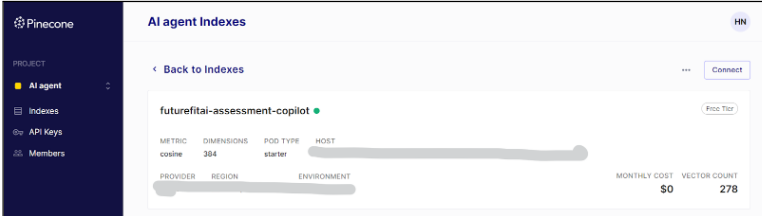

In [ ]:
# pinecone.delete_index(index_name)

### The Code from here creates a constructor for vectorstore from langchain to pinecone

For details of the code please view: https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/schema/vectorstore.py

In [21]:
from langchain.vectorstores import Pinecone

text_field = "text"  # the metadata field that contains our text

vectorstore = Pinecone(
    index, embed_model.embed_query, text_field
)

In [22]:
#This is my resume which i have tries to find a similarity in the vector database
# As most of expereince in in NLP and LLM , i should be able to retrive such Job descriptions form the data.
myresume='''
Hariharavarshan Nandakumar
+1 236 995 3198| hariharavarshan944@gmail.com | LinkedIn |Huggingface

PROFESSIONAL SUMMARY
A Competent management professional and AI expert with 7+ years of cross functional experience that includes Machine
learning, deep learning, predictive modelling, Natural Language Processing and consulting in AI projects and development.
Possess excellent interpersonal, communication and organizational skills with proven abilities in team management,
customer relationship management and planning.
EDUCATION
University of British Columbia, Vancouver, Canada September 2022 – June 2023
Master of Data Science - Computational Linguistics
Projects: Fine Tuning Google LLM(FlanT5), LightGBM classification, House price prediction hosted in FlaskAPI
Anna University, India June 2012 - May 2016
Bachelors of Engineering – Electrical Engineering
TECHNICAL SKILLS
Languages & Tools: Python, SQL, R, PySpark, Pandas, Numpy, Matplotlib, Spacy, Statsmodels, Hugging face, Scikit-learn,
TensorFlow, Pytorch, Keras, Altair, MongoDB, Postgres, Docker, Github, Power BI, Linux GCP, BigQuery, VertexAI, Jira.
Techniques: Machine learning, Deep learning, A/B testing, NLP, T5, Flan T5, BERT, NLU, stochastic gradient descent, LSTM,
Large Language Models (LLM), CNN, NER, Sentiment analysis, Transformers (Attention), clustering, Trees and Graphs.
WORK EXPERIENCE – 7 years
NLP Research Intern - Seasalt.ai, Vancouver Apr 2023 – June 2023
• Researched and Finetuned LLM models such as LLAMA, Alpaca, ChatGPT API to generate Chinese data set for
training Nemo Punctuation toolkit to add Punctuation from ASR raw data with the help of Langchain package. Use
of Hugging face libraries to build RAG and Vector database to add new information to LLMs.
• Used GCP (BigQuery, VertexAI) to design, train and evaluate models on GPUs. Hosted the final fine-tuned models on
GCP for productionizing.
Data Scientist Consultant – HTC Global Mar 2022 – Nov 2022
• To read the Ingredients and Nutrition values from food items package, developed a Transformer architecture with
finetuning BERT and OCR techniques. Deployed models using IAAS such as AWS Lambda, EC2 instance.
• Executed sentiment classification for customer surveys using seq2seq with attention, LSTM models. Work with cross
functional teams to build an MVP product for the final deliverable.
• Deploying the model in ML Ops services to provide end‐to‐end services for frictionless training, validation,
deployment and monitoring of ML models, including a CI/CD component for ML.
• Train and mentor Junior Data Science resources to have an organizational impact. Communicate data driven
solutions to stakeholders about the progress and Insights from the Data. Resource planning for future
Associate Data Scientist – Royal Dutch Shell Jan 2021 – Jan 2022
• Enabling the UK retail team to take action on promotions and statistically (A/B testing) understanding if the
promotion was successful understating grievances mentioned by the customers in the shell GO+ app.
• Crunched text data from app to classify sentiments and recognize entity using Goole’s Flan T5 (LLM) based Algorithm
and NLP augmentation. Deployed using Flask API. Thus increased the customer loyalty score by 8%.

• Utilized ARIMA, SARIMA, exponential smoothing, and LSTM-based models to generate accurate short-term and long-
term sales forecasts, resulting in a 10% reduction in forecast error. Deployed using Flask API.

Senior Data Analyst – Access Health Care Services Nov 2018 – Dec 2020
• Implemented Dynamic Work Allocation frame work by classifying the claims and employees pertaining to fraud by
allocating claims according to their expertise and constraints using LightGBM and XG-Boost. (Supervised and
Unsupervised). Use of PySpark to manage Big Data to manage more than 1M+ claims.
• With Oversampling using SMOTE to balance the classes increased the performance productivity metric of the
workforce by 13.8 % for an employee count of 11,000. The model is containerized using Docker.

Data Analyst – Infosys Ltd June 2016 – Oct 2018
• Developed Neural Network models like LSTM to help the ticket assignment/Ticket Classification faster avoiding
human bias. Created an all-in-one Power BI Dashboard for KPI management system.
AWARDS RECEIVED
• Rising Star of the Year in Access Healthcare Services 2019
• Nominated for Shell.ai awards 2021
CERTIFICATION
• Business Analytics & Intelligence Program 2019-2020
Indian Institute of Management-Bangalore
• Supply chain Analytics 2021
Massachusetts Institute of Technology (MITx) 83%
'''

###### In this example I have used my whole resume and checked if we are able to receive a good response for the same from the Vector DB

In [23]:

data_vector=vectorstore.similarity_search_with_score(myresume,k=5)

In [24]:
data_vector

[(Document(page_content="Responsibilities: Â·Develop and implement machine learning algorithms and models to solve complex business problemsÂ·Collaborate with data scientists, software engineers, and business stakeholders to identify opportunities to apply machine learning to improve business outcomesÂ·Design, develop, and implement end-to-end machine learning systems, including data pre-processing, feature engineering, model training and evaluation, and deploymentÂ·Create and own cloud native API to deploy ML ModelsÂ·Participate in code and design reviews, and contribute to the development of best practices and standards for the machine learning teamÂ·Automate campaigns in a scalable manner to optimize compute and infrastructure cost Qualifications: Â·Bachelor's or Master's degree in Computer Science, Machine Learning, Data Science, or a related fieldÂ·2+ years of experience in machine learning, data science, or a related fieldÂ·Strong programming skills in Python and experience with 

##### As mentioned in the requirements there was also situation where a person might not give the whole resume lets see how such example would generate

- Here we see the responses are quite promising.


In [26]:

query='I have some expereince in Java and node JS, am also good with HTML give me few jobs'
data_vector=vectorstore.similarity_search_with_score(query,k=5)
data_vector
# We can see they are returning completely diffirent text according to the query mentioned above

[(Document(page_content="We are seeking a driven Front-End/Web Developer to join our clientâ€™s personalization platform.', 'As a Web Developer you will aide in our clientâ€™s mission to ease the process for marketers while putting their userâ€™s privacy first.', 'The client seeks candidates with a technical background using JavaScript, HTML, CSS and UX, responsible for building, developing and maintaining website, microsites and APIâ€™s for their customers.', 'You will work with more than 250 brands that the client has built lasting and trusting relationship with over the past two decades.', 'An organized, team player with strong attention to detail will thrive in this job.Job Title:  Front-End DeveloperLocation:  RemoteRequired Technology And SkillsStrong background in JavaScript, HTML, CSS, AWS, and DOM Manipulation3+years of professional developer experience Skilled in user experienceAttention to detail and excellent time management skills Ability to manipulate the DOM using develo

In [ ]:
final_text=''
text_final=[final_text+i[0].page_content+'\n' for i in data_vector]
print(text_final[0])

Responsibilities: Â·Develop and implement machine learning algorithms and models to solve complex business problemsÂ·Collaborate with data scientists, software engineers, and business stakeholders to identify opportunities to apply machine learning to improve business outcomesÂ·Design, develop, and implement end-to-end machine learning systems, including data pre-processing, feature engineering, model training and evaluation, and deploymentÂ·Create and own cloud native API to deploy ML ModelsÂ·Participate in code and design reviews, and contribute to the development of best practices and standards for the machine learning teamÂ·Automate campaigns in a scalable manner to optimize compute and infrastructure cost Qualifications: Â·Bachelor's or Master's degree in Computer Science, Machine Learning, Data Science, or a related fieldÂ·2+ years of experience in machine learning, data science, or a related fieldÂ·Strong programming skills in Python and experience with popular machine learning 

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    temperature=0.5,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=1024,  # mex number of tokens to generate in the output
    repetition_penalty=1.5  # without this output begins repeating
)

from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

In [ ]:
qa_with_sources = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

We can also try to add prompts here to make the retriving more friendly, but with all the available data here the model does a good job of giving a better reponse.

In [ ]:
qa_with_sources.run('''if i am a person with 7+ years of experience in python,
pytorch and have large expereince in NLP with a focus on MLops,
what are the top jobs i can apply for and name the company?''')

' Based on your profile, here are some potential companies and roles where you might fit well! Please note that it’s important not only to meet but also exceed qualification requirements when applying – so highlight those areas which set you apart even further than what meets minimum standards below):\n* Company : Meta / Facebook * Role Title: Software Engineering Manager–AI Research TeamLocation: Menlo Park CA USAOverviewThe ideal candidates must demonstrate expertise leading teams through technical research collaborations spanning various domains including natural language understanding,computational linguistics among others while maintaining high ethical standard sfor responsible innovation within their respective fields.. They would need t ohave excellent written&verbal communicat ion skill sand ability toreasonably break down complex topics intoterms easily digestableby non experts too! This position requires someone whocan manage cross functional project plans effectively ensurin

In [ ]:
# Running the same job description with open AI 3.5 gives a result as shown below
# If run through a Llama70B we much get competitive results as shown below which is very promising as a final copilot output


Certainly, I can provide job recommendations based on the scores mentioned above. Here are the job recommendations along with links to apply:
Machine Learning Engineer at IndusInd Bank
Responsibilities: Developing and implementing machine learning algorithms and models, collaborating with data scientists and software engineers, designing end-to-end machine learning systems, creating cloud-native APIs, and more.
Qualifications: Bachelor's or Master's degree in Computer Science or a related field, 2+ years of experience in machine learning, strong programming skills in Python, experience with popular ML libraries, and more.
Apply here
NLP And GPT Work from Home Job/Internship at Dyeus
Responsibilities: Building AI solutions based on GPT-3 using Python, implementing testing programs, and more.
What They Are Looking For: Strong foundation in Machine Learning, NLP, Python, experience with scientific libraries, and more.
Apply here
Machine Learning Engineer at Tiger Analytics
Responsibiliti